In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import invgamma
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')
mat = data.values

In [3]:
timesteps, nodes = mat.shape
node_numbers = []
for i in range(10,90):
    node_numbers.append(i)
dx = 1e-2
dt = 1e-3

def library_and_y(node_numbers):
    X = None
    y = None
    for p in node_numbers:
        b = np.ones(timesteps)
        d = mat[:,p]
        d1 = (mat[:,p+1] - mat[:,p-1])/(2*dx)
        d2 = (mat[:,p+1] + mat[:,p-1] - 2*mat[:,p])/dx**2
        d3 = (mat[:,p+2] - 2*mat[:,p+1] + 2*mat[:,p-1] - mat[:,p-2])/(2*dx**3)
        d4 = (mat[:,p+2] - 4*mat[:,p+1] + 6*mat[:,p] - 4*mat[:,p-1] + mat[:,p-2] )/dx**4
        d5 = (mat[:,p+3] - 5*mat[:,p+2] + 10*mat[:,p+1] - 10*mat[:,p-1] + 5*mat[:,p-2] - mat[:,p-3]) / (2*dx**5)

        d6 = (mat[:,p+3] - 6*mat[:,p+2] + 15*mat[:,p+1] - 20*mat[:,p] + 15*mat[:,p-1] -
              6*mat[:,p-2] + mat[:,p-3])/(dx**6)

        dcos = np.cos(d)
        dsin = np.sin(d)

        dt2 = np.ones(timesteps)
        dt1 = np.ones(timesteps)
        
        for i in range(1,timesteps-1):
          dt2[i] = (mat[i+1,p] + mat[i-1,p] - 2*mat[i,p])/dt**2
          dt1[i] = (mat[i+1,p] - mat[i-1,p] )/(2*dt)
        temp = np.vstack((d, d1, d2, d3, d4, d5, d6, d*d1, d*d2, d*d3, d*d4 , d*d5, d*d6,
               d1*d2, d2*d3, d3*d4, d4*d5, d5*d6, dcos, dsin, d1*d3, d3*d5, d2*d4,
               d1*d4, d2*d5, d3*d6, dcos*d1, dsin*d1, dsin*d4,d**2)).T[1:-1]
        if X is None:
            X = temp
        else:
            X = np.vstack((X,temp))
        if y is None:
            y = dt2[1:-1]
        else:
            y = np.hstack((y,dt2[1:-1]))
    return X,y



X,y = library_and_y(node_numbers)
scaler = StandardScaler()


np.set_printoptions(threshold = np.inf)
X = X[10:-10:10,:]
Y = y[10:-10:10]
print(X.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

a = np.random.rand(30) 
(np.dot(X,a)).shape


(15982, 30)
(15982,)


(15982,)

Sequential sampling (1 chains in 1 job)
NUTS: [l, tau, c2, z, group_sd]


Sampling 1 chain for 2_000 tune and 5_000 draw iterations (2_000 + 5_000 draws total) took 1080 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


array([[<Axes: title={'center': 'pn\n0'}>,
        <Axes: title={'center': 'pn\n1'}>,
        <Axes: title={'center': 'pn\n2'}>,
        <Axes: title={'center': 'pn\n3'}>],
       [<Axes: title={'center': 'pn\n4'}>,
        <Axes: title={'center': 'pn\n5'}>,
        <Axes: title={'center': 'pn\n6'}>,
        <Axes: title={'center': 'pn\n7'}>],
       [<Axes: title={'center': 'pn\n8'}>,
        <Axes: title={'center': 'pn\n9'}>,
        <Axes: title={'center': 'pn\n10'}>,
        <Axes: title={'center': 'pn\n11'}>],
       [<Axes: title={'center': 'pn\n12'}>,
        <Axes: title={'center': 'pn\n13'}>,
        <Axes: title={'center': 'pn\n14'}>,
        <Axes: title={'center': 'pn\n15'}>],
       [<Axes: title={'center': 'pn\n16'}>,
        <Axes: title={'center': 'pn\n17'}>,
        <Axes: title={'center': 'pn\n18'}>,
        <Axes: title={'center': 'pn\n19'}>],
       [<Axes: title={'center': 'pn\n20'}>,
        <Axes: title={'center': 'pn\n21'}>,
        <Axes: title={'center': 'pn\n

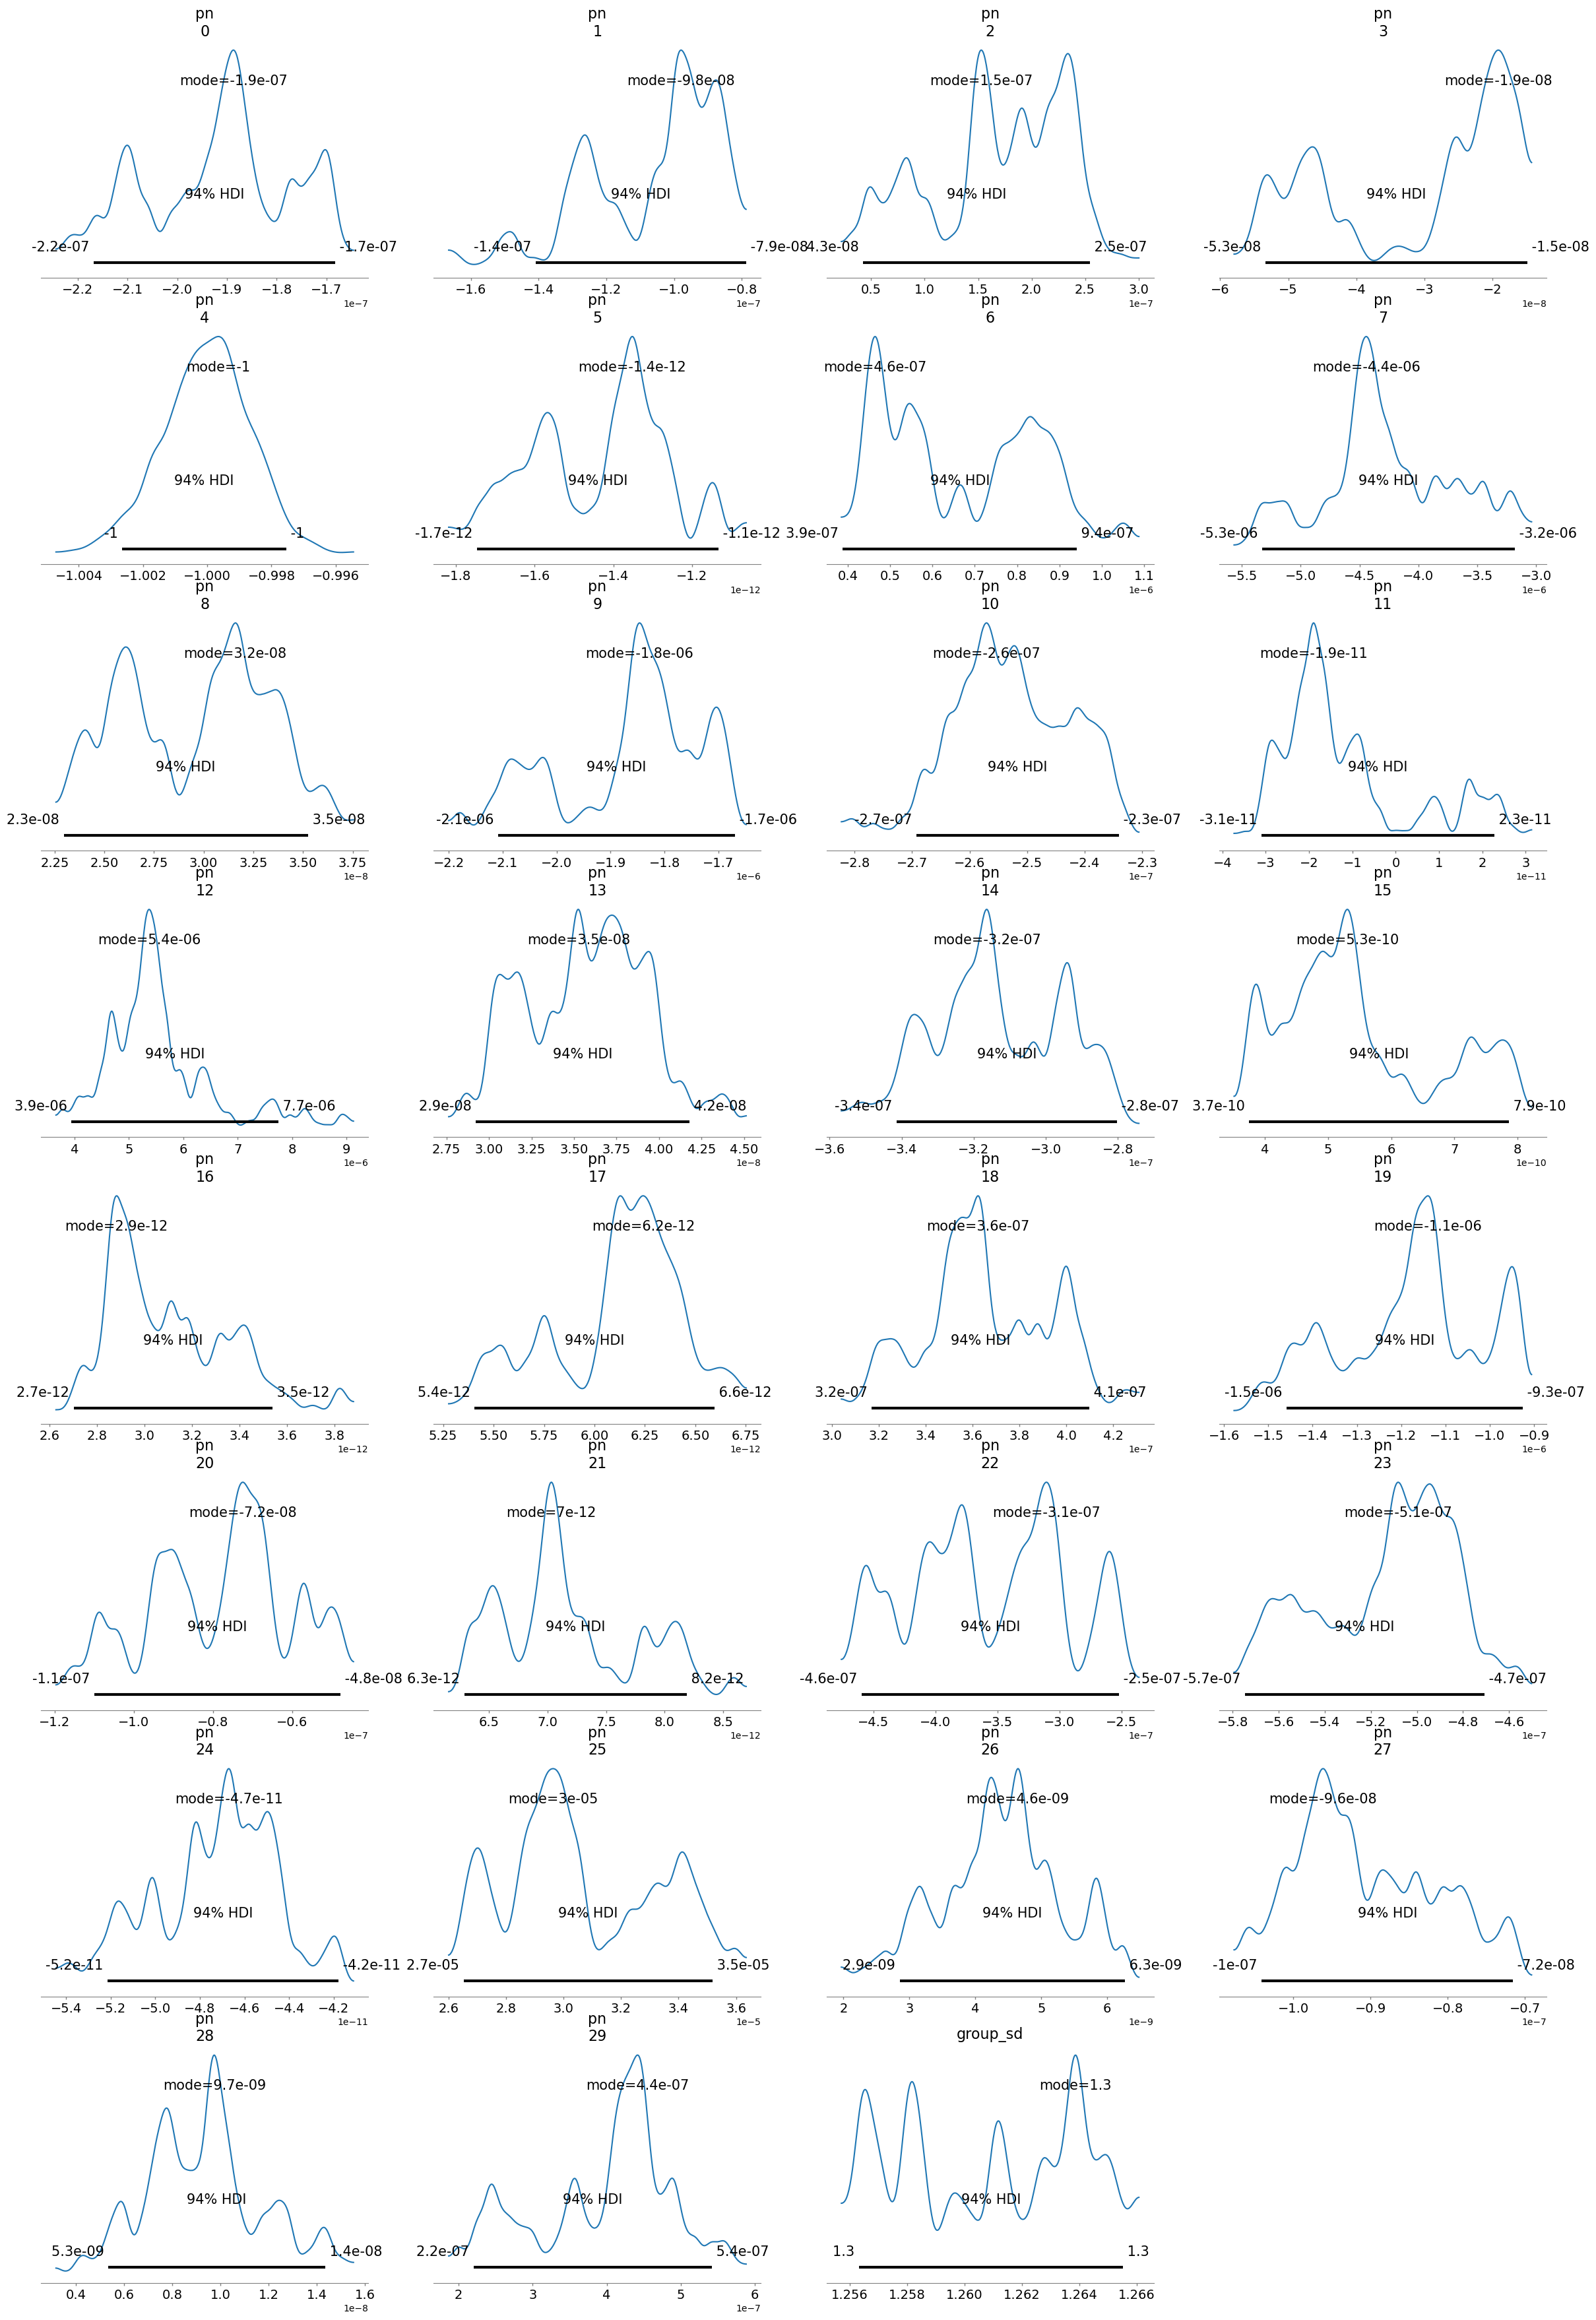

In [75]:
import pymc as pm
import numpy as np
d = 30
slab_scale = 10
slab_df = 1

# Define the model
with pm.Model() as model:
    l = pm.HalfStudentT('l', nu=1, sigma=0.1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    c2 = pm.InverseGamma('c2', alpha=0.5 * slab_df, beta=0.5 * slab_df * slab_scale**2)
    lt = pm.Deterministic('lt', c2* pm.math.sqr(l) /(c2 + pm.math.sqr(tau) * pm.math.sqr(l)))
    z = pm.Normal('z', mu=0, sigma=1, shape=(30,))
    pn = pm.Deterministic('pn', z * pm.math.sqr(tau) * lt)
    
    dot_product = pm.math.dot(X_train, pn)

    group_sd = pm.InverseGamma('group_sd', alpha=1, beta=0.1)
    likelihood = pm.Normal('likelihood', mu=dot_product, sigma=group_sd, observed=y_train)

    # Sample from the model
    step = pm.NUTS(target_accept=0.4, max_treedepth=10)
    # trace = pm.sample(2000, tune=6000, random_seed=1,target_accept=0.98)
    trace = pm.sample(5000, tune=2000,  step = step, random_seed=1,chains = 1)
    trace = trace.sel(draw=slice(1000, None))
summary = pm.summary(trace)
pm.plot_posterior(trace, var_names=['pn', 'group_sd'],point_estimate='mode')

array([[<Axes: title={'center': 'pn\n0'}>,
        <Axes: title={'center': 'pn\n1'}>,
        <Axes: title={'center': 'pn\n2'}>,
        <Axes: title={'center': 'pn\n3'}>],
       [<Axes: title={'center': 'pn\n4'}>,
        <Axes: title={'center': 'pn\n5'}>,
        <Axes: title={'center': 'pn\n6'}>,
        <Axes: title={'center': 'pn\n7'}>],
       [<Axes: title={'center': 'pn\n8'}>,
        <Axes: title={'center': 'pn\n9'}>,
        <Axes: title={'center': 'pn\n10'}>,
        <Axes: title={'center': 'pn\n11'}>],
       [<Axes: title={'center': 'pn\n12'}>,
        <Axes: title={'center': 'pn\n13'}>,
        <Axes: title={'center': 'pn\n14'}>,
        <Axes: title={'center': 'pn\n15'}>],
       [<Axes: title={'center': 'pn\n16'}>,
        <Axes: title={'center': 'pn\n17'}>,
        <Axes: title={'center': 'pn\n18'}>,
        <Axes: title={'center': 'pn\n19'}>],
       [<Axes: title={'center': 'pn\n20'}>,
        <Axes: title={'center': 'pn\n21'}>,
        <Axes: title={'center': 'pn\n

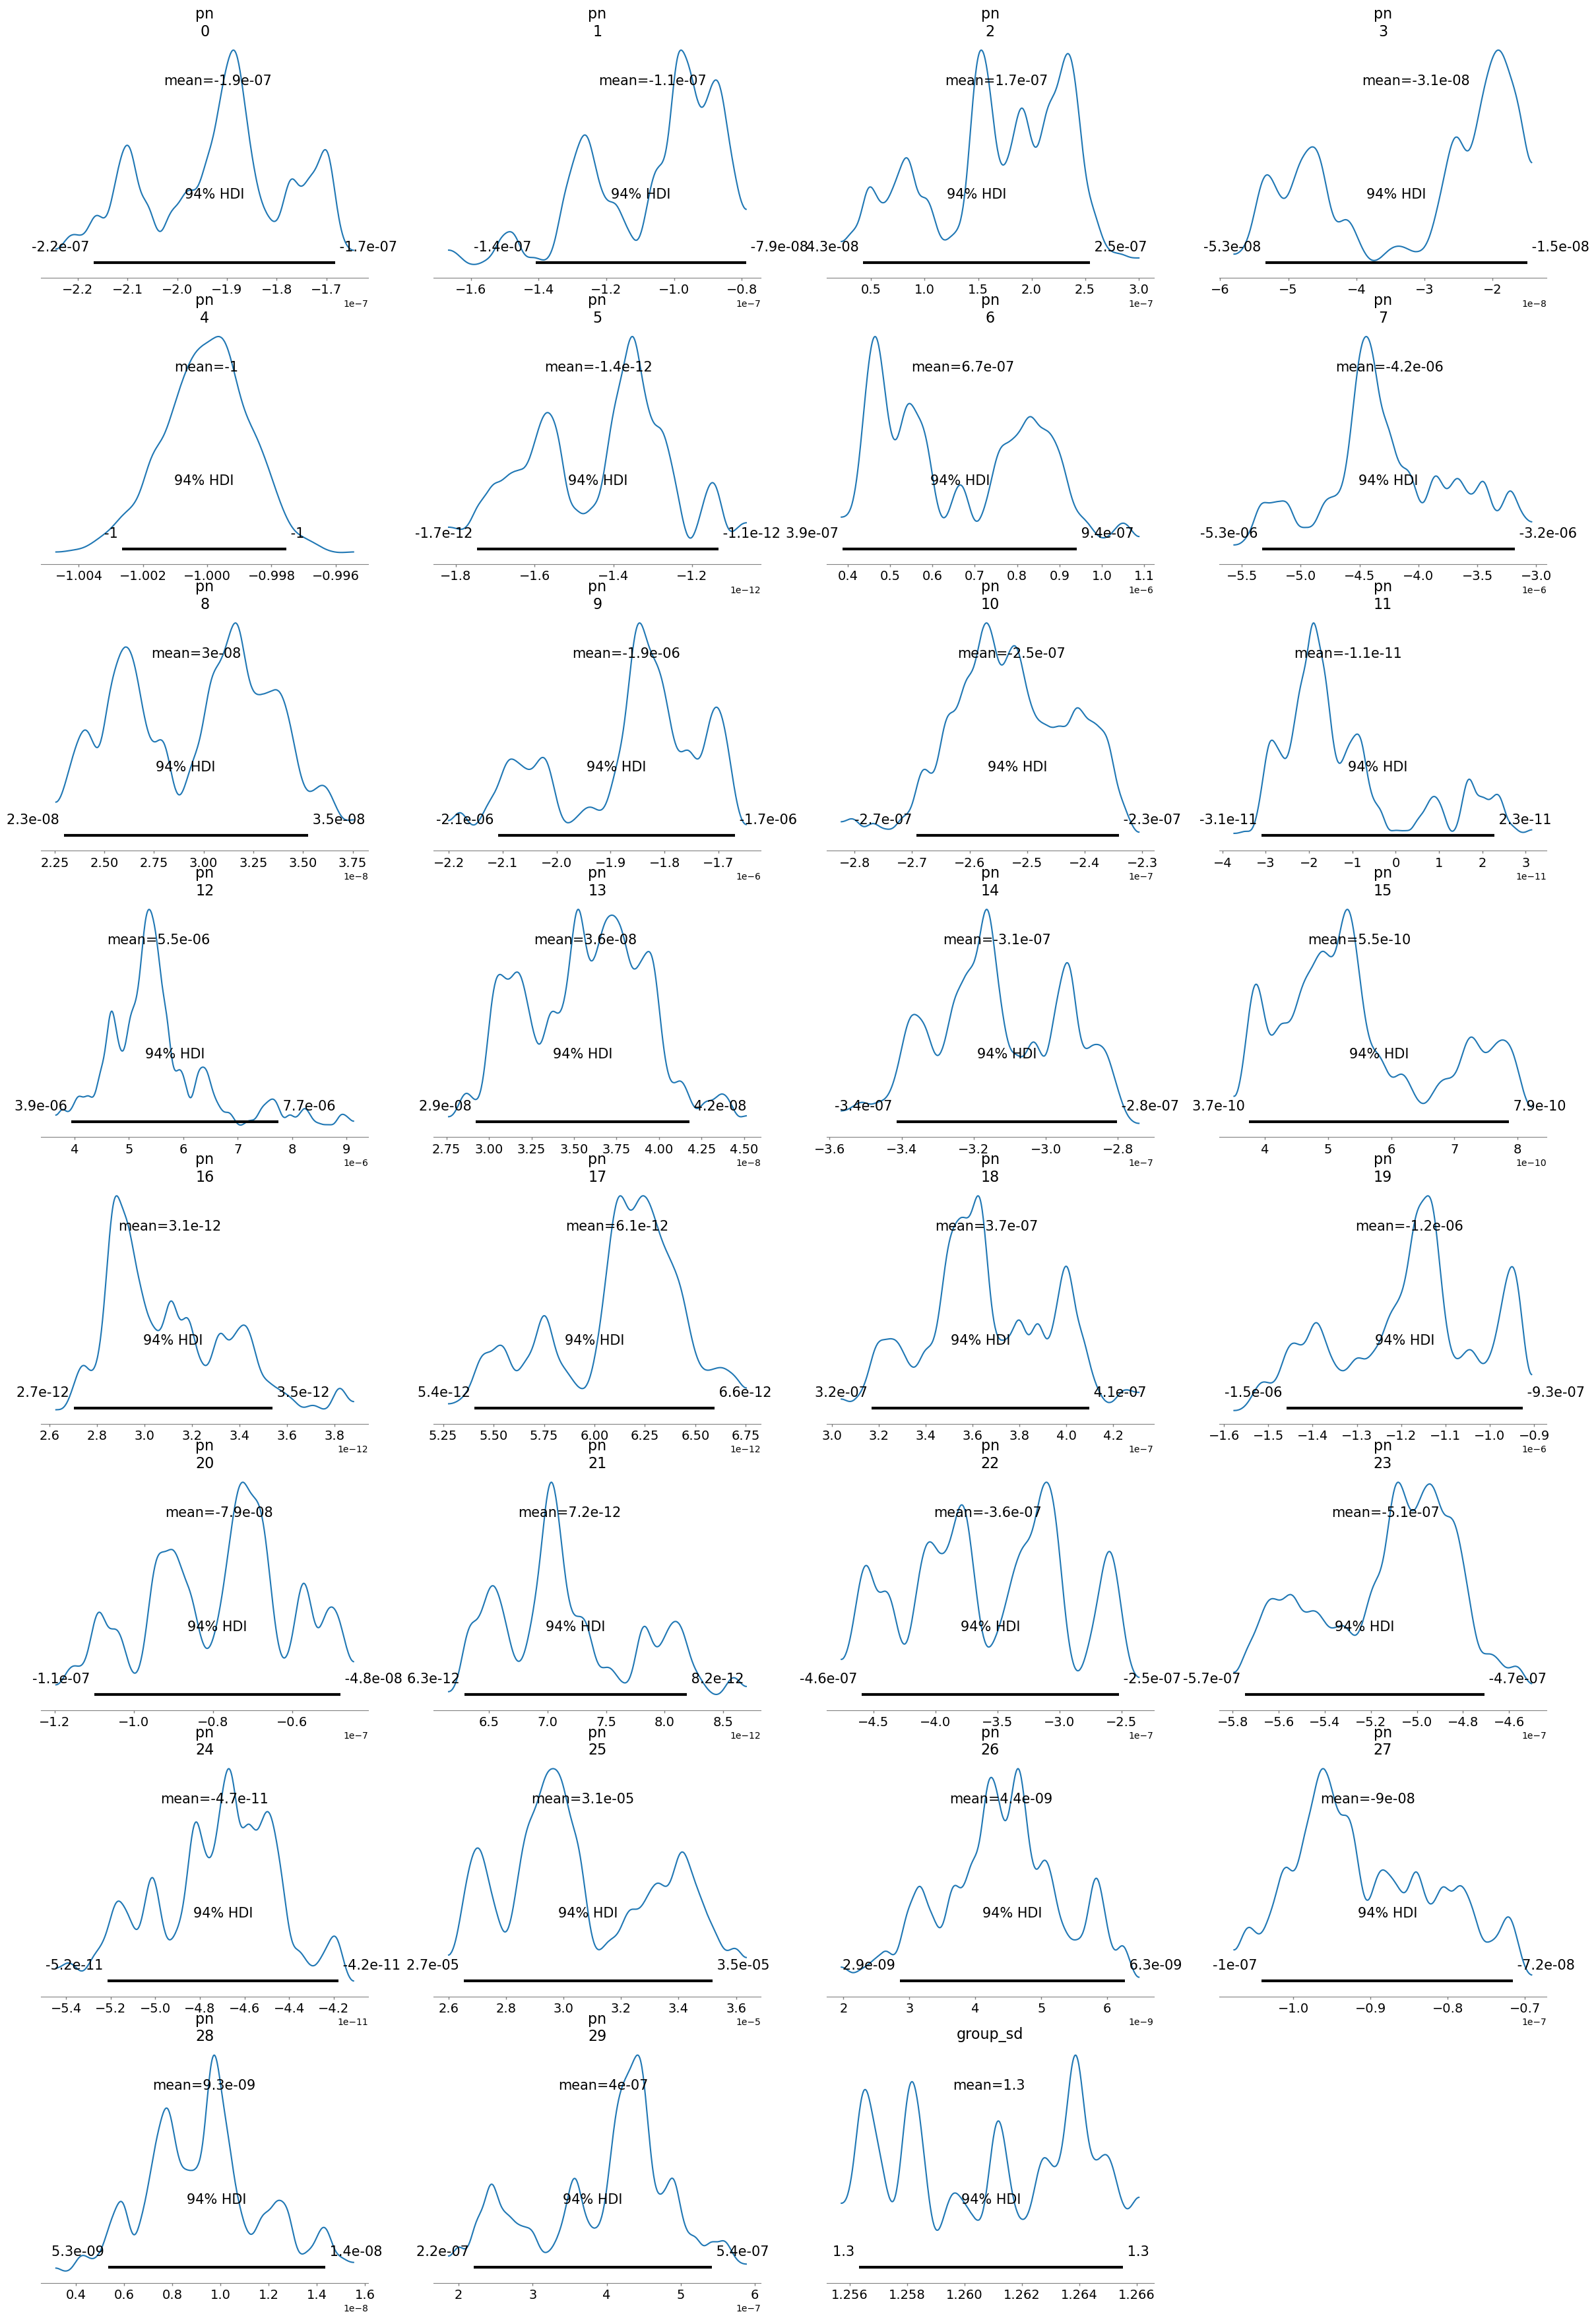

In [76]:

pm.plot_posterior(trace, var_names=['pn', 'group_sd'])